In [1]:
from astropy.io import fits
from astropy import units, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner 
from voigt_fit_lib import *
import os
import pickle
from scipy import interpolate

Load in the files

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

First, the FUV files

In [3]:
spec_fits_fuv = fits.open(rootdir + 'FUV/PG1522+101_FUV_wavecal_new.fits')
lsf_fits_fuv = fits.open(rootdir + 'FUV/PG1522_COS_FUV_wavcal2022_lsf_ZQ.fits')

Then, the NUV files

In [4]:
spec_fits_nuv = fits.open(rootdir + 'G185M/PG1522+101_NUV_wavecal_new.fits')
lsf_fits_nuv = fits.open(rootdir + 'G185M/PG1522_COS_NUV_wavcal2022_lsf.fits')

Then, the STIS files

In [5]:
spec_fits_stis = fits.open(rootdir + 'STIS/PG1522+101_E230M_new.fits')
lsf_fits_stis = fits.open(rootdir + 'STIS/PG1522_STIS_NUV_wavcal2022_lsf.fits')

Then, the HIRES files

In [6]:
spec_fits_hires = fits.open(rootdir + 'HIRES/PG1522+101_HIRES.fits')
lsf_fits_hires = fits.open(rootdir + 'HIRES/PG1522_HIRES_wavcal2023_lsf.fits')

Compile a list of the spectra, continuum nodes, and IDs for all detectors

In [7]:
spec_fits_list = [spec_fits_fuv, spec_fits_nuv, spec_fits_stis, spec_fits_hires]
lsf_fits_list = [lsf_fits_fuv, lsf_fits_nuv, lsf_fits_stis, lsf_fits_hires]

Systemic redshift

In [8]:
z_sys = 0.67545705

# CII 1036

In [9]:
cii_1036_fuv = ion_transition('CII', 1036, 'C', z_sys, 'FUV')

In [10]:
cii_1036_fuv.grab_ion_transition_info()

In [11]:
cii_1036_fuv.grab_ion_transition_spec(spec_fits_list)

In [12]:
cii_1036_fuv.cont_norm_flux(v_abs_range=[-100,100], degree=1)

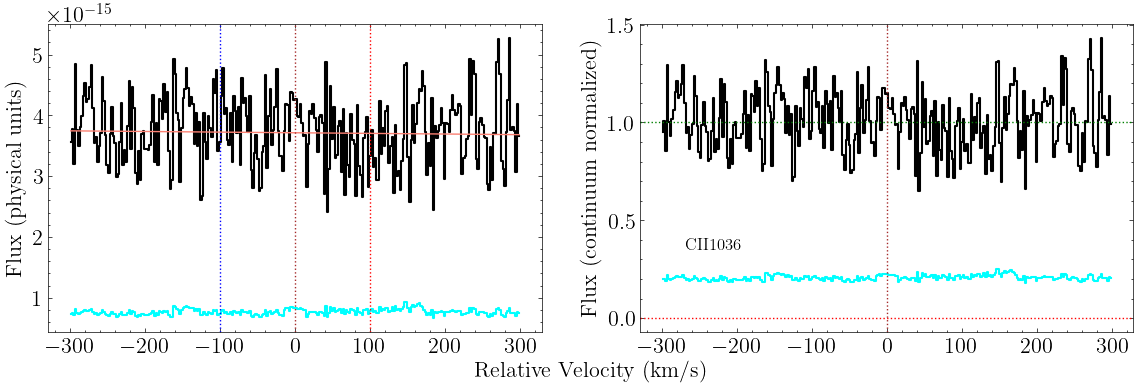

In [13]:
fig, axes = cii_1036_fuv.plot_ion_transition_spec_cont()

In [14]:
cii_1036_fuv.grab_ion_transition_lsf(lsf_fits_list)

Re-define variables

In [15]:
v = cii_1036_fuv.v
flux_obs = cii_1036_fuv.flux_norm
err_std = cii_1036_fuv.err_norm

In [154]:
b = 10

Define function for constructing a Voigt profile

In [155]:
def vp(v, logN, lsf_convolve=True):
    
    model = comp_model_spec_gen(v, np.array([[logN, b, 0]]), 
                                cii_1036_fuv.wav0_rest, cii_1036_fuv.f, cii_1036_fuv.gamma, cii_1036_fuv.A,
                                lsf_convolve,
                                cii_1036_fuv.lsf, cii_1036_fuv.v_lsf)[1]
    
    return model

(-0.2, 1.5)

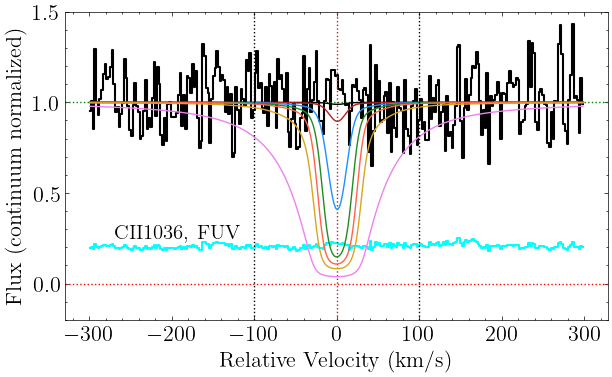

In [156]:
fig, ax = cii_1036_fuv.plot_ion_transition_spec()
ax.plot(v, vp(v, 12), color='black', label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 12, b=30 \ \mathrm{km/s}$')
ax.plot(v, vp(v, 13), label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 13, b=30 \ \mathrm{km/s}$', color='firebrick')
ax.plot(v, vp(v, 14), label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 14, b=30 \ \mathrm{km/s}$', color='dodgerblue')
ax.plot(v, vp(v, 15), label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 15, b=30 \ \mathrm{km/s}$', color='forestgreen')
ax.plot(v, vp(v, 16), label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 15, b=30 \ \mathrm{km/s}$', color='tomato')
ax.plot(v, vp(v, 17), label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 15, b=30 \ \mathrm{km/s}$', color='goldenrod')
ax.plot(v, vp(v, 18), label=r'$\log(N_\mathrm{CII}/\mathrm{cm}^{-2}) = 15, b=30 \ \mathrm{km/s}$', color='violet')

#ax.legend(fontsize=10)

ax.axvline(-100, linestyle=':')
ax.axvline(100, linestyle=':')

ax.set_xlabel(r'Relative Velocity (km/s)')
ax.set_ylabel('Flux (continuum normalized)')

ax.set_ylim(-0.2,1.5)

Construct a mock profile to test convolution and measure the new FWHM

In [157]:
# Unconvolved and convolved profiles
mock_unconv = vp(v, 13, False)
mock_conv = vp(v, 13, True)

# Flux levels for FWHM in each profile
flux_fwhm_unconv = 1-0.5*(1-np.min(mock_unconv))
flux_fwhm_conv = 1-0.5*(1-np.min(mock_conv))

# Corresponding FWHM calculation
fwhm_unconv = 2*v[v>0][np.argmin(np.abs(mock_unconv[v>0]-flux_fwhm_unconv))]
fwhm_conv = 2*v[v>0][np.argmin(np.abs(mock_conv[v>0]-flux_fwhm_conv))]

In [158]:
np.sum(1-mock_conv), np.sum(1-mock_unconv)

(1.4420052203541278, 1.4424589233488425)

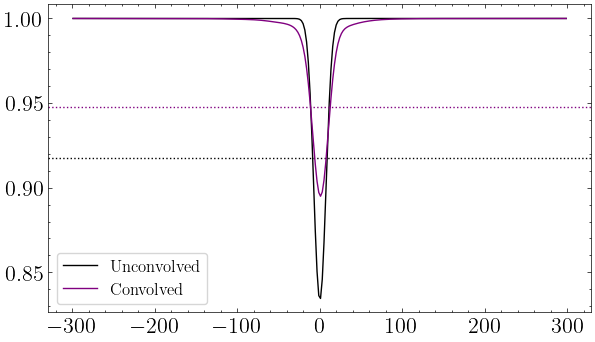

In [159]:
fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(v, mock_unconv, label='Unconvolved', color='black')
ax.axhline(flux_fwhm_unconv, color='black', linestyle=':')
ax.plot(v, mock_conv, label='Convolved', color='purple')
ax.axhline(flux_fwhm_conv, color='purple', linestyle=':')
ax.legend()

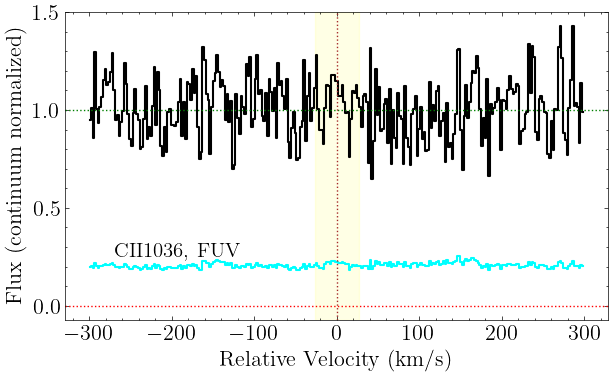

In [160]:
fig, ax = cii_1036_fuv.plot_ion_transition_spec()
ax.axvspan(xmin=-fwhm_conv, xmax=fwhm_conv, color='yellow', alpha=.1)

Generate noisy samples

In [161]:
N_samples = 3000
noise_grid = np.zeros((N_samples, len(v)))

# For each spectral pixel
for k in range(len(v)):
    # Generate noise for all logN, for each trial
    noise_samples = np.random.normal(loc=1, scale=err_std[k], size=N_samples)
    # Save the reshaped noise in the larger grid
    noise_grid[:,k] = noise_samples

In [162]:
trials_indices = np.random.randint(low=0, high=N_samples, size=4)

In [163]:
idx = (v>-100)&(v<100)

Text(0, 0.5, 'Flux (continuum normalized)')

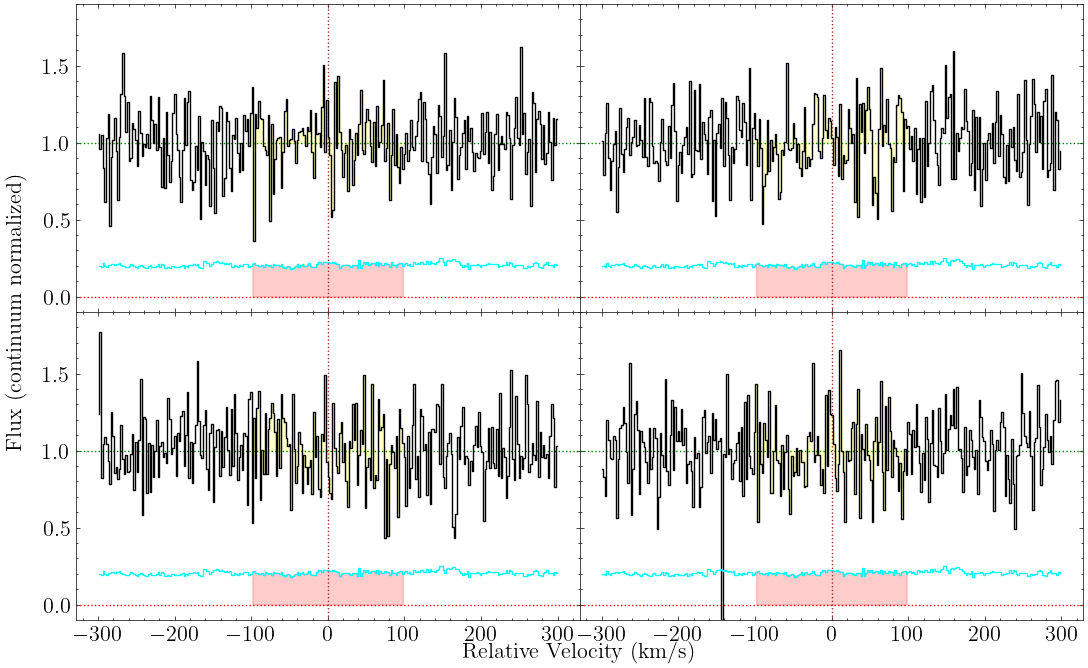

In [164]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

axes[0,0].set_ylim(-0.1, 1.9)

for i in range(len(trials_indices)):
    
    ax = axes[i//2, i%2]
    ax.axvline(0, linestyle=':', color='brown')
    ax.axhline(0, linestyle=':', color='red')
    ax.axhline(1, linestyle=':', color='green')
    trial_idx = trials_indices[i]
    ax.step(v, noise_grid[trial_idx, :], where='mid')
    ax.step(v, err_std, where='mid', color='cyan')
    ax.fill_between(v[idx], noise_grid[trial_idx, :][idx], y2=1, color='yellow', alpha=.2)
    ax.fill_between(v[idx], err_std[idx], y2=0, color='red', alpha=.2)
    #ax.axvspan(xmin=v[idx][0], xmax=v[idx][-1], color='yellow', alpha=.1)
    
plt.subplots_adjust(wspace=0, hspace=0)   

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel('Relative Velocity (km/s)', labelpad=15) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel('Flux (continuum normalized)', labelpad=35)

Get distributions for EW

In [165]:
def calc_EW(v, flux_obs):

    delta_lambda = np.mean(((v[1:]-v[:-1])*cii_1036_fuv.wav0_rest/3e+5)*1e+3) # in mA
    EW = np.sum((1-flux_obs[:-1])*delta_lambda) # Mimic integration

    return EW

In [166]:
def calc_EW1sig(v, err_std):
    
    delta_lambda = np.mean(((v[1:]-v[:-1])*cii_1036_fuv.wav0_rest/3e+5)*1e+3) # in mA
    EW_1sig = np.sqrt(np.sum((err_std[:-1]*delta_lambda)**2))

    return EW_1sig

In [167]:
EW_dist = np.zeros(N_samples)

for i in range(N_samples):
    EW_dist[i] = calc_EW(v[idx], noise_grid[i,:][idx])
    
EW_1sig = calc_EW1sig(v[idx], err_std[idx])

In [168]:
from scipy.stats import norm, chi2

Text(0, 0.5, 'PDF')

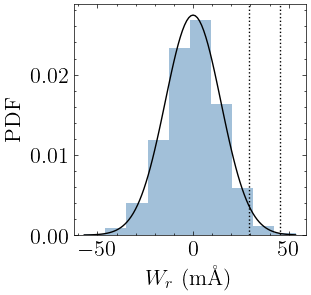

In [169]:
fig, ax = plt.subplots(1, figsize=(3,3))

xrange = np.linspace(np.min(EW_dist),np.max(EW_dist),100)
ax.hist(EW_dist, color='steelblue', alpha=.5, density=True)
ax.plot(xrange, norm.pdf(xrange, loc=0, scale=EW_1sig))

ax.axvline(np.percentile(EW_dist, 100*cdf_2sig), linestyle=':')

ax.axvline(np.percentile(EW_dist, 100*cdf_3sig), linestyle=':')

ax.set_xlabel(r'$W_r \ (\mathrm{mÅ})$')
ax.set_ylabel(r'PDF')

Map $\log N$ to  EW

In [170]:
# Generate clean models
logN_grid = np.linspace(12.5, 15.0, 100) 
#logN_grid = np.log10(np.linspace(10**12.0, 10**13.5, 200))

model_grid = np.zeros((len(logN_grid), len(v)))

for j in range(len(logN_grid)):
    model_grid[j,:] = vp(v, logN_grid[j])

In [171]:
EW_model = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    EW_model[j] = calc_EW(v[idx], model_grid[j,:][idx])

In [172]:
EW_linear = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    N = 10**logN_grid[j]
    EW_linear[j] = (cii_1036_fuv.wav0_rest/1e-3)*N*(2.654e-2*cii_1036_fuv.f)*(3e+8/(cii_1036_fuv.wav0_rest*1e-10))**-1

Text(0, 0.5, '$W_r \\ (\\mathrm{mÅ})$')

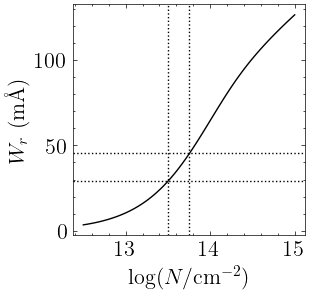

In [173]:
fig, ax = plt.subplots(1,figsize=(3,3))

ax.plot(logN_grid, EW_model)
#ax.plot(logN_grid, EW_linear, label='Linear')

ax.axhline(np.percentile(EW_dist, 100*cdf_2sig), linestyle=':')
ax.axhline(np.percentile(EW_dist, 100*cdf_3sig), linestyle=':')

ax.axvline(np.interp(np.percentile(EW_dist, 100*cdf_2sig), EW_model, logN_grid), linestyle=':')
ax.axvline(np.interp(np.percentile(EW_dist, 100*cdf_3sig), EW_model, logN_grid), linestyle=':')

#ax.legend()

ax.set_xlabel(r'$\log(N/\mathrm{cm}^{-2})$')
ax.set_ylabel(r'$W_r \ (\mathrm{mÅ})$')

In [174]:
np.interp(np.percentile(EW_dist, 100*cdf_2sig), EW_model, logN_grid)

13.505213300547346

In [175]:
np.interp(np.percentile(EW_dist, 100*cdf_3sig), EW_model, logN_grid)

13.755351271592263

Generate mock signals and compute $W_r$ for each

In [99]:
# Generate noisy signals
signal_grid = np.zeros((N_samples, len(logN_grid), len(v)))
EW_sig_grid = np.zeros((N_samples, len(logN_grid)))

for i in range(N_samples):
    for j in range(len(logN_grid)):
        # Add trial noise and clean model 

        #signal_grid[i,j,:] = (1+noise_grid[i,:])*model_grid[j,:]
        signal_grid[i,j,:] = (noise_grid[i,:]-1)+model_grid[j,:]
        EW_sig_grid[i,j] = calc_EW(v[idx], signal_grid[i,j,:][idx])

Draw some mock signals

In [116]:
logN_plot = 13.5
logN_idx = np.where(np.round(logN_grid, 1) == logN_plot)[0][0]

In [117]:
logN_grid[logN_idx]

13.45959595959596

In [118]:
trials_indices = np.random.randint(low=0, high=N_samples, size=4)

Text(0, 0.5, 'Flux (continuum normalized)')

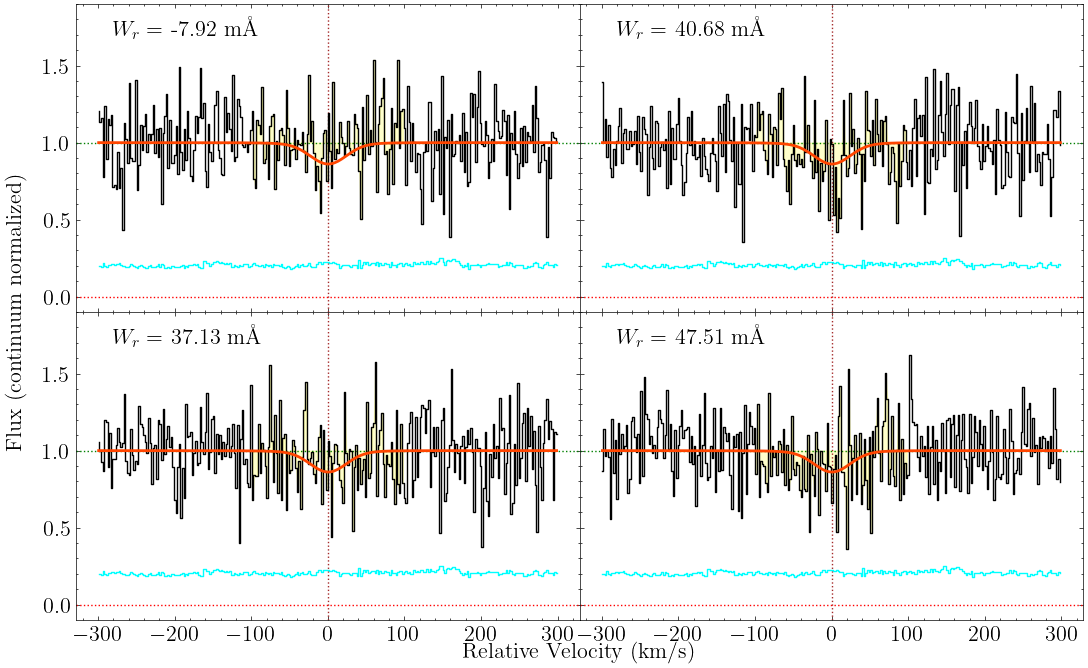

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

axes[0,0].set_ylim(-0.1, 1.9)

for i in range(len(trials_indices)):
    
    ax = axes[i//2, i%2]
    ax.axvline(0, linestyle=':', color='brown')
    ax.axhline(0, linestyle=':', color='red')
    ax.axhline(1, linestyle=':', color='green')
    trial_idx = trials_indices[i]
    ax.step(v, signal_grid[trial_idx, logN_idx, :], where='mid')
    ax.plot(v, model_grid[logN_idx, :], color='orangered', lw=2)
    ax.fill_between(v[idx], signal_grid[trial_idx, logN_idx, :][idx], y2=1, color='yellow', alpha=.2)
    ax.step(v, err_std, where='mid', color='cyan')
    #ax.axvspan(xmin=v[idx][0], xmax=v[idx][-1], color='yellow', alpha=.1)
    ax.text(x=-280, y=1.7, s=r'$W_r = $'+' {:.2f}'.format(EW_sig_grid[trial_idx, logN_idx])+' mÅ')
    
plt.subplots_adjust(wspace=0, hspace=0)   

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel('Relative Velocity (km/s)', labelpad=15) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel('Flux (continuum normalized)', labelpad=35)

Make the detection probability curve

In [100]:
p_EW_2sig = np.zeros(len(logN_grid))
p_EW_3sig = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    p_EW_2sig[j] = np.sum(EW_sig_grid[:,j]>2*EW_1sig)/N_samples
    p_EW_3sig[j] = np.sum(EW_sig_grid[:,j]>3*EW_1sig)/N_samples

In [105]:
2*EW_1sig, 3*EW_1sig

(29.10857618357759, 43.66286427536639)

Text(0, 0.5, '$p_\\mathrm{det}$')

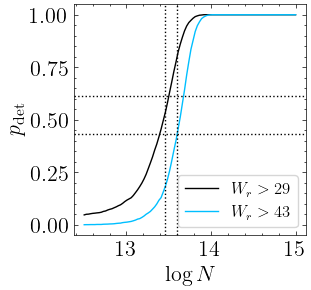

In [145]:
fig, ax = plt.subplots(1,figsize=(3,3))

ax.plot(logN_grid, p_EW_2sig, label=r'$W_r > 29$')
ax.plot(logN_grid, p_EW_3sig, label=r'$W_r > 43$')

ax.axvline(np.interp(np.percentile(EW_dist, 100*cdf_2sig), EW_model, logN_grid), linestyle=':')
ax.axvline(np.interp(np.percentile(EW_dist, 100*cdf_3sig), EW_model, logN_grid), linestyle=':')

ax.axhline(np.interp(13.5, logN_grid, p_EW_2sig), linestyle=':')
ax.axhline(np.interp(13.6, logN_grid, p_EW_3sig), linestyle=':')

ax.legend()
ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$p_\mathrm{det}$')

In [108]:
np.interp(13.5, logN_grid, p_EW_2sig), np.interp(13.6, logN_grid, p_EW_2sig)

(0.6115333333333334, 0.8021733333333325)

Get distribution for $\chi_0^2$

$$\chi^2_0 = \sum_{i=1}^k \frac{(f_i-1)^2}{\sigma_i^2}$$

In [122]:
chi_sq0_dist = np.zeros(N_samples)

for i in range(N_samples):
    chi_sq0_dist[i] = np.sum((noise_grid[i,:][idx]-1)**2/err_std[idx]**2)

Text(0, 0.5, 'PDF')

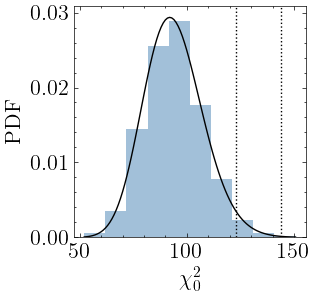

In [123]:
fig, ax = plt.subplots(1, figsize=(3,3))

xrange = np.linspace(np.min(chi_sq0_dist),np.max(chi_sq0_dist),100)
ax.hist(chi_sq0_dist, color='steelblue', alpha=.5, density=True)
ax.plot(xrange, chi2.pdf(xrange, len(v[idx])))

ax.axvline(np.percentile(chi_sq0_dist, 100*cdf_2sig), linestyle=':')
ax.axvline(np.percentile(chi_sq0_dist, 100*cdf_3sig), linestyle=':')

ax.set_xlabel(r'$\chi^2_0$')
ax.set_ylabel(r'PDF')

In [130]:
chi_sq0_2sig = np.percentile(chi_sq0_dist, 100*cdf_2sig)
chi_sq0_3sig = np.percentile(chi_sq0_dist, 100*cdf_3sig)

In [131]:
chi_sq0_2sig, chi_sq0_3sig

(122.9788278786134, 144.02924277252126)

Clean model mapping

In [132]:
chi_sq0_model = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    chi_sq0_model[j] = np.sum((model_grid[j,:][idx]-1)**2/err_std[idx]**2)

Text(0, 0.5, '$\\chi^2_0$')

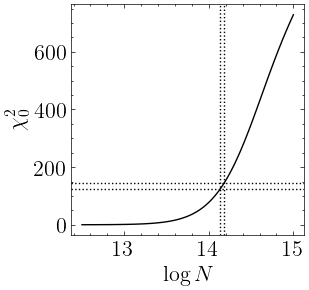

In [133]:
fig, ax = plt.subplots(1,figsize=(3,3))

ax.plot(logN_grid, chi_sq0_model)

ax.axhline(np.percentile(chi_sq0_dist, 100*cdf_2sig), linestyle=':')
ax.axhline(np.percentile(chi_sq0_dist, 100*cdf_3sig), linestyle=':')

ax.axvline(np.interp(np.percentile(chi_sq0_dist, 100*cdf_2sig), chi_sq0_model, logN_grid), linestyle=':')
ax.axvline(np.interp(np.percentile(chi_sq0_dist, 100*cdf_3sig), chi_sq0_model, logN_grid), linestyle=':')

ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$\chi^2_0$')

In [134]:
np.interp(np.percentile(chi_sq0_dist, 100*cdf_2sig), chi_sq0_model, logN_grid)

14.131122268725546

In [135]:
np.interp(np.percentile(chi_sq0_dist, 100*cdf_3sig), chi_sq0_model, logN_grid)

14.17918573217464

$\chi^2_0$ for mock signals

In [136]:
# Generate noisy signals
chi_sq0_sig_grid = np.zeros((N_samples, len(logN_grid)))

for i in range(N_samples):
    for j in range(len(logN_grid)):
        chi_sq0_sig_grid[i,j] = np.sum((signal_grid[i,j,:][idx]-1)**2/err_std[idx]**2)

Draw some mock samples

In [151]:
logN_plot = 13.5
logN_idx = np.where(np.round(logN_grid, 1) == logN_plot)[0][0]

In [152]:
logN_grid[logN_idx]

13.45959595959596

In [118]:
trials_indices = np.random.randint(low=0, high=N_samples, size=4)

Text(0, 0.5, 'Flux (continuum normalized)')

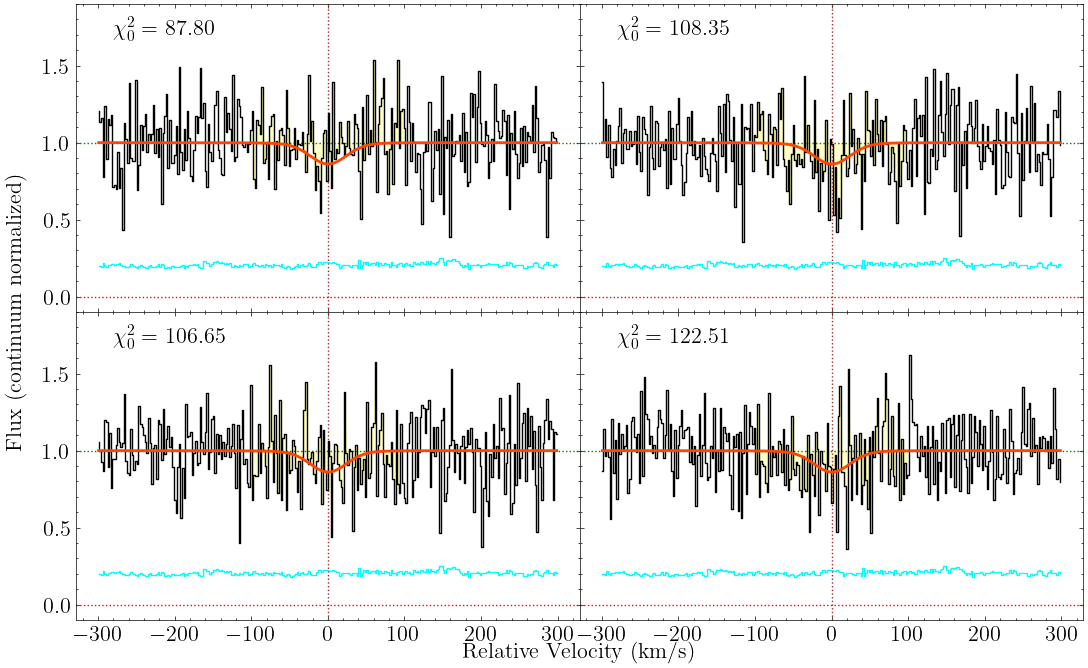

In [153]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

axes[0,0].set_ylim(-0.1, 1.9)

for i in range(len(trials_indices)):
    
    ax = axes[i//2, i%2]
    ax.axvline(0, linestyle=':', color='brown')
    ax.axhline(0, linestyle=':', color='red')
    ax.axhline(1, linestyle=':', color='green')
    trial_idx = trials_indices[i]
    ax.step(v, signal_grid[trial_idx, logN_idx, :], where='mid')
    ax.plot(v, model_grid[logN_idx, :], color='orangered', lw=2)
    ax.fill_between(v[idx], signal_grid[trial_idx, logN_idx, :][idx], y2=1, color='yellow', alpha=.2)
    ax.step(v, err_std, where='mid', color='cyan')
    #ax.axvspan(xmin=v[idx][0], xmax=v[idx][-1], color='yellow', alpha=.1)
    ax.text(x=-280, y=1.7, s=r'$\chi_0^2 = $'+' {:.2f}'.format(chi_sq0_sig_grid[trial_idx, logN_idx]))
    
plt.subplots_adjust(wspace=0, hspace=0)   

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel('Relative Velocity (km/s)', labelpad=15) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel('Flux (continuum normalized)', labelpad=35)

In [137]:
p_chi_sq0_2sig = np.zeros(len(logN_grid))
p_chi_sq0_3sig = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    p_chi_sq0_2sig[j] = np.sum(chi_sq0_sig_grid[:,j]>chi_sq0_2sig)/N_samples
    p_chi_sq0_3sig[j] = np.sum(chi_sq0_sig_grid[:,j]>chi_sq0_3sig)/N_samples

Text(0, 0.5, '$p_\\mathrm{det}$')

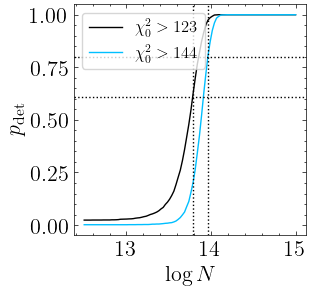

In [150]:
fig, ax = plt.subplots(1,figsize=(3,3))

ax.plot(logN_grid, p_chi_sq0_2sig, label=r'$\chi_0^2 > 123$')
ax.plot(logN_grid, p_chi_sq0_3sig, label=r'$\chi_0^2 > 144$')

ax.axhline(0.61, linestyle=':')
ax.axhline(0.8, linestyle=':')

ax.axvline(np.interp(0.61, p_chi_sq0_2sig, logN_grid), linestyle=':')
ax.axvline(np.interp(0.8, p_chi_sq0_3sig, logN_grid), linestyle=':')

ax.legend()
ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$p_\mathrm{det}$')

In [147]:
np.interp(0.61, p_chi_sq0_2sig, logN_grid)

13.783110070663719

In [148]:
np.interp(0.8, p_chi_sq0_3sig, logN_grid)

13.962606837606836